<a href="https://colab.research.google.com/github/Sanjana998/MusicGenreClassifier/blob/master/MusicGenreClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing modules for feature extraction and preprocessing

In [ ]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import seaborn as sns
#pre-processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [ ]:
path = '/content/drive/My Drive/img_data/'

creating spectrograms of the audio data files

In [ ]:
cmap = plt.get_cmap('inferno')     # sets the colourmap for the graph to inferno style
plt.figure(figsize=(8,8))          # sets the plot size to 8*8 inches
genres = 'blues classical country disco hiphop metal pop reggae rock'.split()

for g in genres:
    pathlib.Path(f'{path}{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/My Drive/genres/{g}'):
        songname = f'/content/drive/My Drive/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'/content/drive/My Drive/img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

creating feature headers for the dataset that will be generated

In [ ]:
header = 'filename chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var	perceptr_mean perceptr_var tempo'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'
header += ' label'
header = header.split()

extracting features from audio files and storing them in a csv file

In [ ]:
file = open('/content/drive/MyDrive/features_3_sec.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/My Drive/genres/{g}'):
        songname = f'/content/drive/My Drive/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr = sum(zcr)
        harm, perc = librosa.effects.hpss(y)
        tempo = librosa.beat.tempo(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {np.mean(harm)} {np.var(harm)} {np.mean(perc)} {np.var(perc)} {np.mean(tempo)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)} {np.var(e)}'
        to_append += f' {g}'
        file = open('/content/drive/My Drive/dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

KeyboardInterrupt: ignored

loading the dataset and checking the first 5 rows 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/features_3_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


checking the shape of dataset

In [ ]:
data.shape

(9990, 60)

removing the filenames from the dataset to make predictions independent of the file name

In [ ]:
data = data.drop(['filename'],axis=1)

In [ ]:
data.shape

(9990, 59)

Encoding the genres into numerical format using the LabelEncoder

In [ ]:
genre_list = data.iloc[:, -1]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

In [ ]:
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
y = data['label']
X = data.drop('label', axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

implementing Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.26745621, 0.18238003])

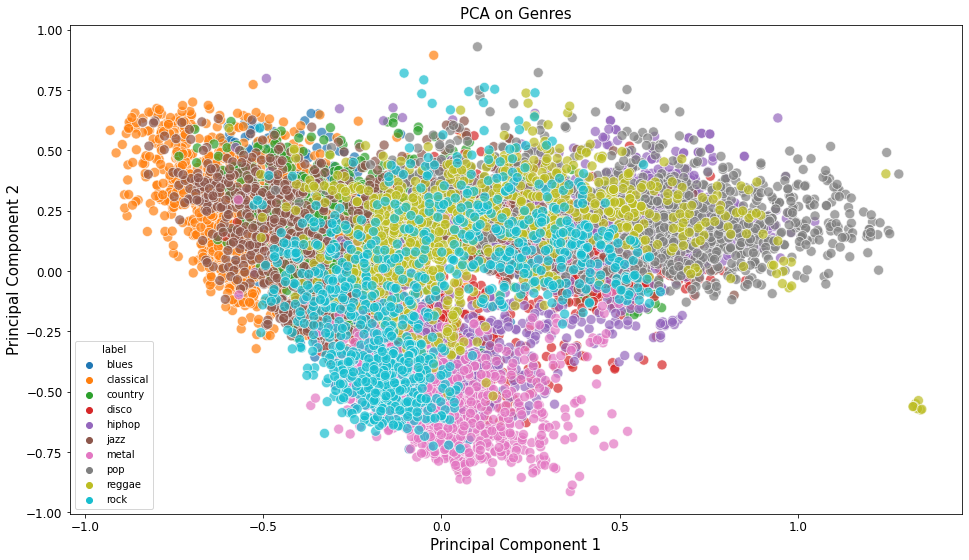

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")


importing modules for classification and anaylsis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
# Feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE

training the model and generating the confusion matrix

In [ ]:
def model_build(model, kf, title = "Default"):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
    print("Accuracy score of", title, "is:", round(np.mean(accuracy_scores), 2))
    # Let's see the confusion matrix of the last split for a little insight
    con_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (16, 9))
    sns.heatmap(con_mat, cmap="Blues", annot=True, 
                xticklabels = ["blues", "classical", "country", "disco", 
                               "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                yticklabels=["blues", "classical", "country", "disco", "hiphop", 
                             "jazz", "metal", "pop", "reggae", "rock"])
    plt.show()

In [ ]:
split = KFold(n_splits=5, shuffle=True)

In [ ]:
X_train, X_validation , Y_train , Y_validation = train_test_split(X, y ,test_size=0.2 , random_state=1)

In [ ]:
Y_train

1041    classical
6764        metal
8889       reggae
4299       hiphop
1178    classical
          ...    
2895      country
7813          pop
905         blues
5192         jazz
235         blues
Name: label, Length: 7992, dtype: object

Implementing Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=10)


Accuracy score of Random Forest Classifier is: 0.81


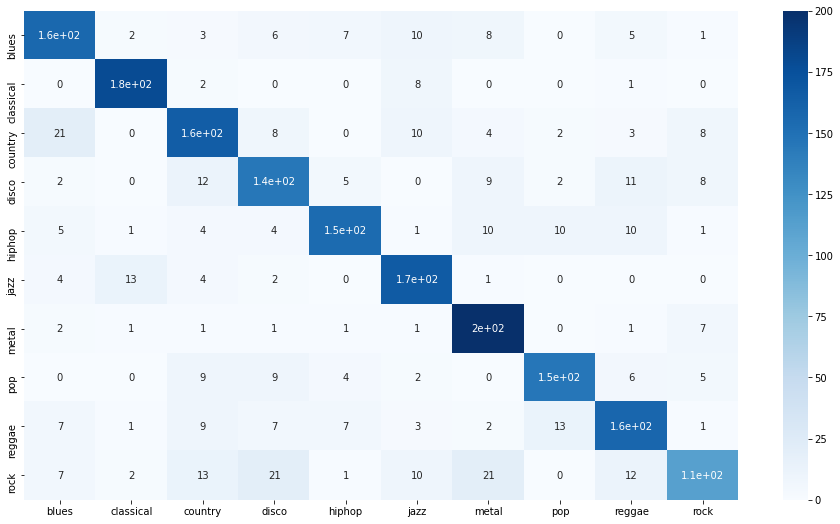

In [ ]:
model_build(rfc, split, 'Random Forest Classifier')

Implementing KNN Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)

Accuracy score of K Nearest Neighbor is: 0.65


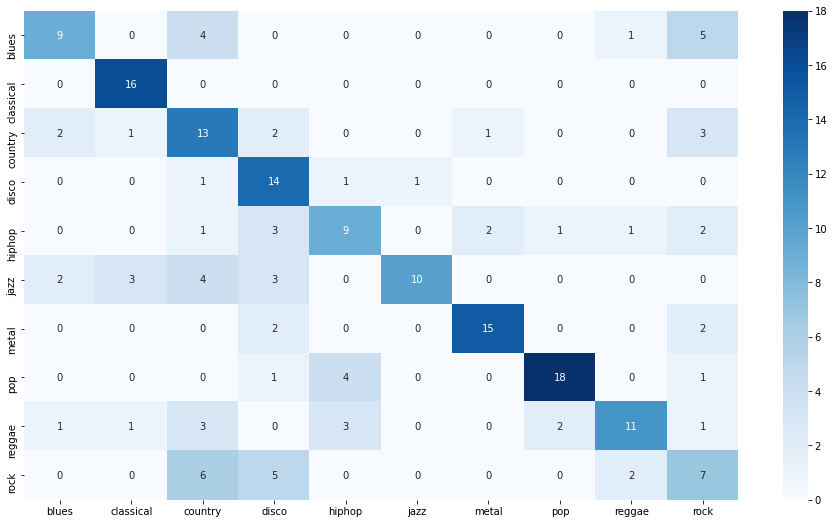

In [ ]:
model_build(knn, split, 'K Nearest Neighbor')

Implementing Xtreme Gradient Boosting Classifier

In [ ]:
xgb = XGBClassifier()

Accuracy score of XG Boost is: 0.71


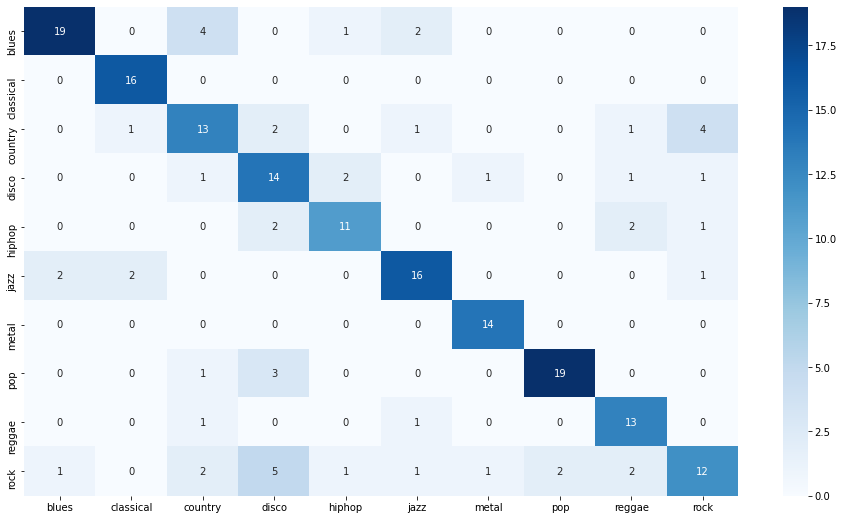

In [ ]:
model_build(xgb, split, 'XG Boost')

Implementing Support Vector Machine Classifier

In [ ]:
svm = SVC(decision_function_shape="ovo")

Accuracy score of Support Vector Machine is: 0.69


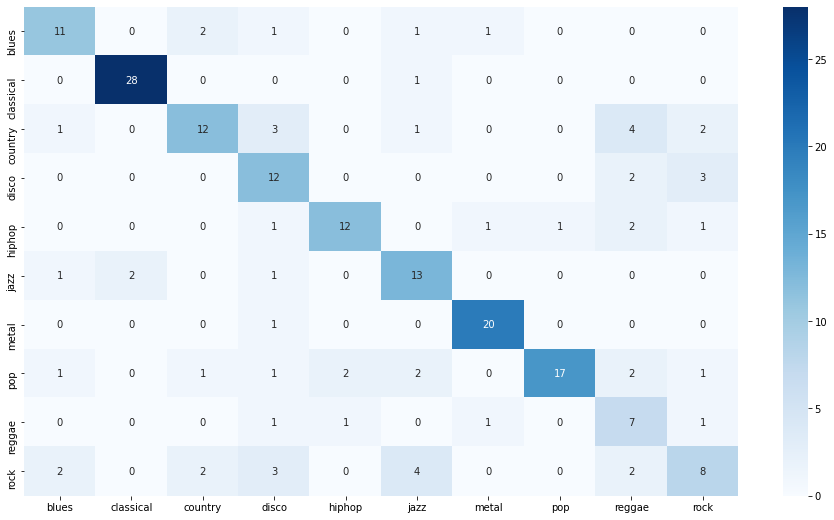

In [ ]:
model_build(svm, split, 'Support Vector Machine')

Using Random Forest Classifier for final testing

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=1)
model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=10)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, y_pred), 5))

Accuracy : 0.81105


In [ ]:
pip install eli5


     |████████████████████████████████| 112kB 6.3MB/s 


Using eli5 module to check the importance and contribution of each feature towards classification

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=model, random_state=1)
perm.fit(X_test, y_test)


In [ ]:
columns = data.drop('label', axis=1).columns.tolist()
eli5.show_weights(estimator=perm, feature_names = columns)

Weight,Feature
0.0208 ± 0.0118,mfcc4_mean
0.0128 ± 0.0128,rms_var
0.0120 ± 0.0134,chroma_stft_var
0.0112 ± 0.0234,chroma_stft_mean
0.0104 ± 0.0165,mfcc9_mean
0.0088 ± 0.0032,tempo
0.0080 ± 0.0051,mfcc14_mean
0.0072 ± 0.0032,mfcc16_var
0.0072 ± 0.0155,mfcc12_mean
0.0072 ± 0.0118,spectral_centroid_mean


In [ ]:
songname = input("Enter path :")

Enter path :/content/drive/MyDrive/genres/hiphop/hiphop.00001.wav


In [ ]:
file = open('/content/drive/My Drive/datasettest.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
fname = songname.split('/')[-1]
y, sr = librosa.load(songname, mono=True, duration=30)
rms = librosa.feature.rms(y=y)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
zcr = sum(zcr)
harm, perc = librosa.effects.hpss(y)
tempo = librosa.beat.tempo(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
to_append = f'{fname} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {np.mean(harm)} {np.var(harm)} {np.mean(perc)} {np.var(perc)} {np.mean(tempo)}'    
for e in mfcc:
  to_append += f' {np.mean(e)} {np.var(e)}'
file = open('/content/drive/My Drive/datasettest.csv', 'a', newline='')
with file:
  writer = csv.writer(file)
  writer.writerow(to_append.split())

/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


In [ ]:
data = pd.read_csv('/content/drive/My Drive/datasettest.csv')
data.head()

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,hiphop.00001.wav,0.457321,0.090098,0.285714,0.006848,2808.099768,939251.846891,2441.374589,158280.721457,5527.499909,2.077318e+06,0.097649,0.005135,2.155427e-07,0.060938,-0.000183,0.016481,92.285156,-81.113258,3652.544352,49.599606,915.553706,-14.549536,990.922913,57.982455,323.390559,6.843361,386.668337,27.147628,254.769394,-6.849032,183.805582,31.309706,147.132695,-10.073357,139.31624,20.325103,88.933773,-2.530991,112.951804,12.747554,78.422281,3.974185,103.20452,13.235183,74.808998,-2.37351,75.424785,12.263859,66.556131,-7.043196,67.75167,4.747927,58.274021,1.869254,57.137352,0.020621,67.60231,NaN


In [ ]:
data = data.drop(['filename'],axis=1)

In [ ]:
y = data['label']
X = data.drop('label', axis=1)

In [ ]:
y = model.predict(X)
y

array(['hiphop'], dtype=object)